# Installing Necessary Packages + Imports

In [1]:
%%capture
!python3 -m pip install spuco

In [2]:
from spuco.evaluate import Evaluator
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.robust_train import ERM, GroupBalanceBatchERM
from spuco.evaluate import Evaluator

import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt

# Download and Load Dataset
[default parameters taken from here](https://github.com/BigML-CS-UCLA/SpuCo/blob/master/quickstart/spuco_mnist/spuco_mnist_george.py)

In [3]:
%%capture

train_ds = SpuCoMNIST(root = './data/mnist', 
                     spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
                     spurious_correlation_strength=0.995,
                     classes=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
                     split="train",
                     download=True,
                    )

val_ds = SpuCoMNIST(root = './data/mnist', 
                     spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
                     classes=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
                     split="val"
                    )

test_ds = SpuCoMNIST(root = './data/mnist', 
                     spurious_feature_difficulty=SpuriousFeatureDifficulty.MAGNITUDE_LARGE,
                     classes=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
                     split="test"
                    )

train_ds.initialize()
val_ds.initialize()
test_ds.initialize()

# Initialize + Train ERM Model

use small resnet backbone, adam optimizer

In [4]:
from timm import create_model
cnn = create_model('resnet10t',pretrained=False,num_classes=5)
base_cnn_weights = cnn.state_dict()

val_evaluator = Evaluator(
    testset=val_ds,
    group_partition=val_ds.group_partition,
    group_weights=val_ds.group_weights,
    batch_size=64,
    model=cnn,
    device='cpu',
)
trainer = ERM(model = cnn, 
          trainset = train_ds, 
          batch_size = 64, 
          optimizer = torch.optim.Adam(cnn.parameters(),lr = 1e-3), 
          num_epochs=1, 
          criterion=nn.CrossEntropyLoss(),
          verbose=True
          )
trainer.train()

Epoch 0: 100%|██████████| 751/751 [02:52<00:00,  4.37batch/s, accuracy=75.0%, loss=1.43]


# Evaluate base ERM + Cluster

In [5]:
evaluator = Evaluator(
    testset=test_ds,
    group_partition=test_ds.group_partition,
    group_weights=train_ds.group_weights,
    batch_size=64,
    model=cnn,
    device='cpu',
    verbose=True
)
evaluator.evaluate()
print('worse accuracy',evaluator.worst_group_accuracy)
print('average group accuracy',evaluator.average_accuracy)
print('spurious_attribute_prediction',evaluator.evaluate_spurious_attribute_prediction())

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:13,  1.74it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:13,  1.76it/s]

Group (0, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:12,  1.76it/s]

Group (0, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:02<00:11,  1.77it/s]

Group (0, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:11,  1.76it/s]

Group (0, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:10,  1.75it/s]

Group (1, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:03<00:10,  1.78it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:09,  1.78it/s]

Group (1, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:08,  1.79it/s]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:05<00:08,  1.79it/s]

Group (1, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:07,  1.81it/s]

Group (2, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:06<00:07,  1.85it/s]

Group (2, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:07<00:06,  1.87it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:07<00:05,  1.90it/s]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:08<00:05,  1.90it/s]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:08<00:04,  1.88it/s]

Group (3, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:09<00:04,  1.86it/s]

Group (3, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:09<00:03,  1.86it/s]

Group (3, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:10<00:03,  1.85it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:10<00:02,  1.83it/s]

Group (3, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:11<00:02,  1.82it/s]

Group (4, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:12<00:01,  1.82it/s]

Group (4, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:12<00:01,  1.83it/s]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:13<00:00,  1.65it/s]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]

Group (4, 4) Accuracy: 100.0
worse accuracy ((0, 1), 0.0)
average group accuracy 99.49379218398467


spurious_attribute_prediction 100.0


In [6]:
outputs = []
labels = []
for i in range(len(val_ds)):
    img, label = val_ds[i]
    output = cnn(torch.tensor(img).unsqueeze(0)).squeeze().detach().cpu().numpy()
    outputs.append(output)
    labels.append(label)
    
outputs = np.array(outputs)
labels = np.array(labels)

# make 5 clusters
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=5,)
cluster.fit(outputs)
predicted_groups = cluster.predict(outputs)
predicted_groups

/tmp/ipykernel_17/1916144679.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = cnn(torch.tensor(img).unsqueeze(0)).squeeze().detach().cpu().numpy()
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 3, 2, ..., 2, 0, 0], dtype=int32)

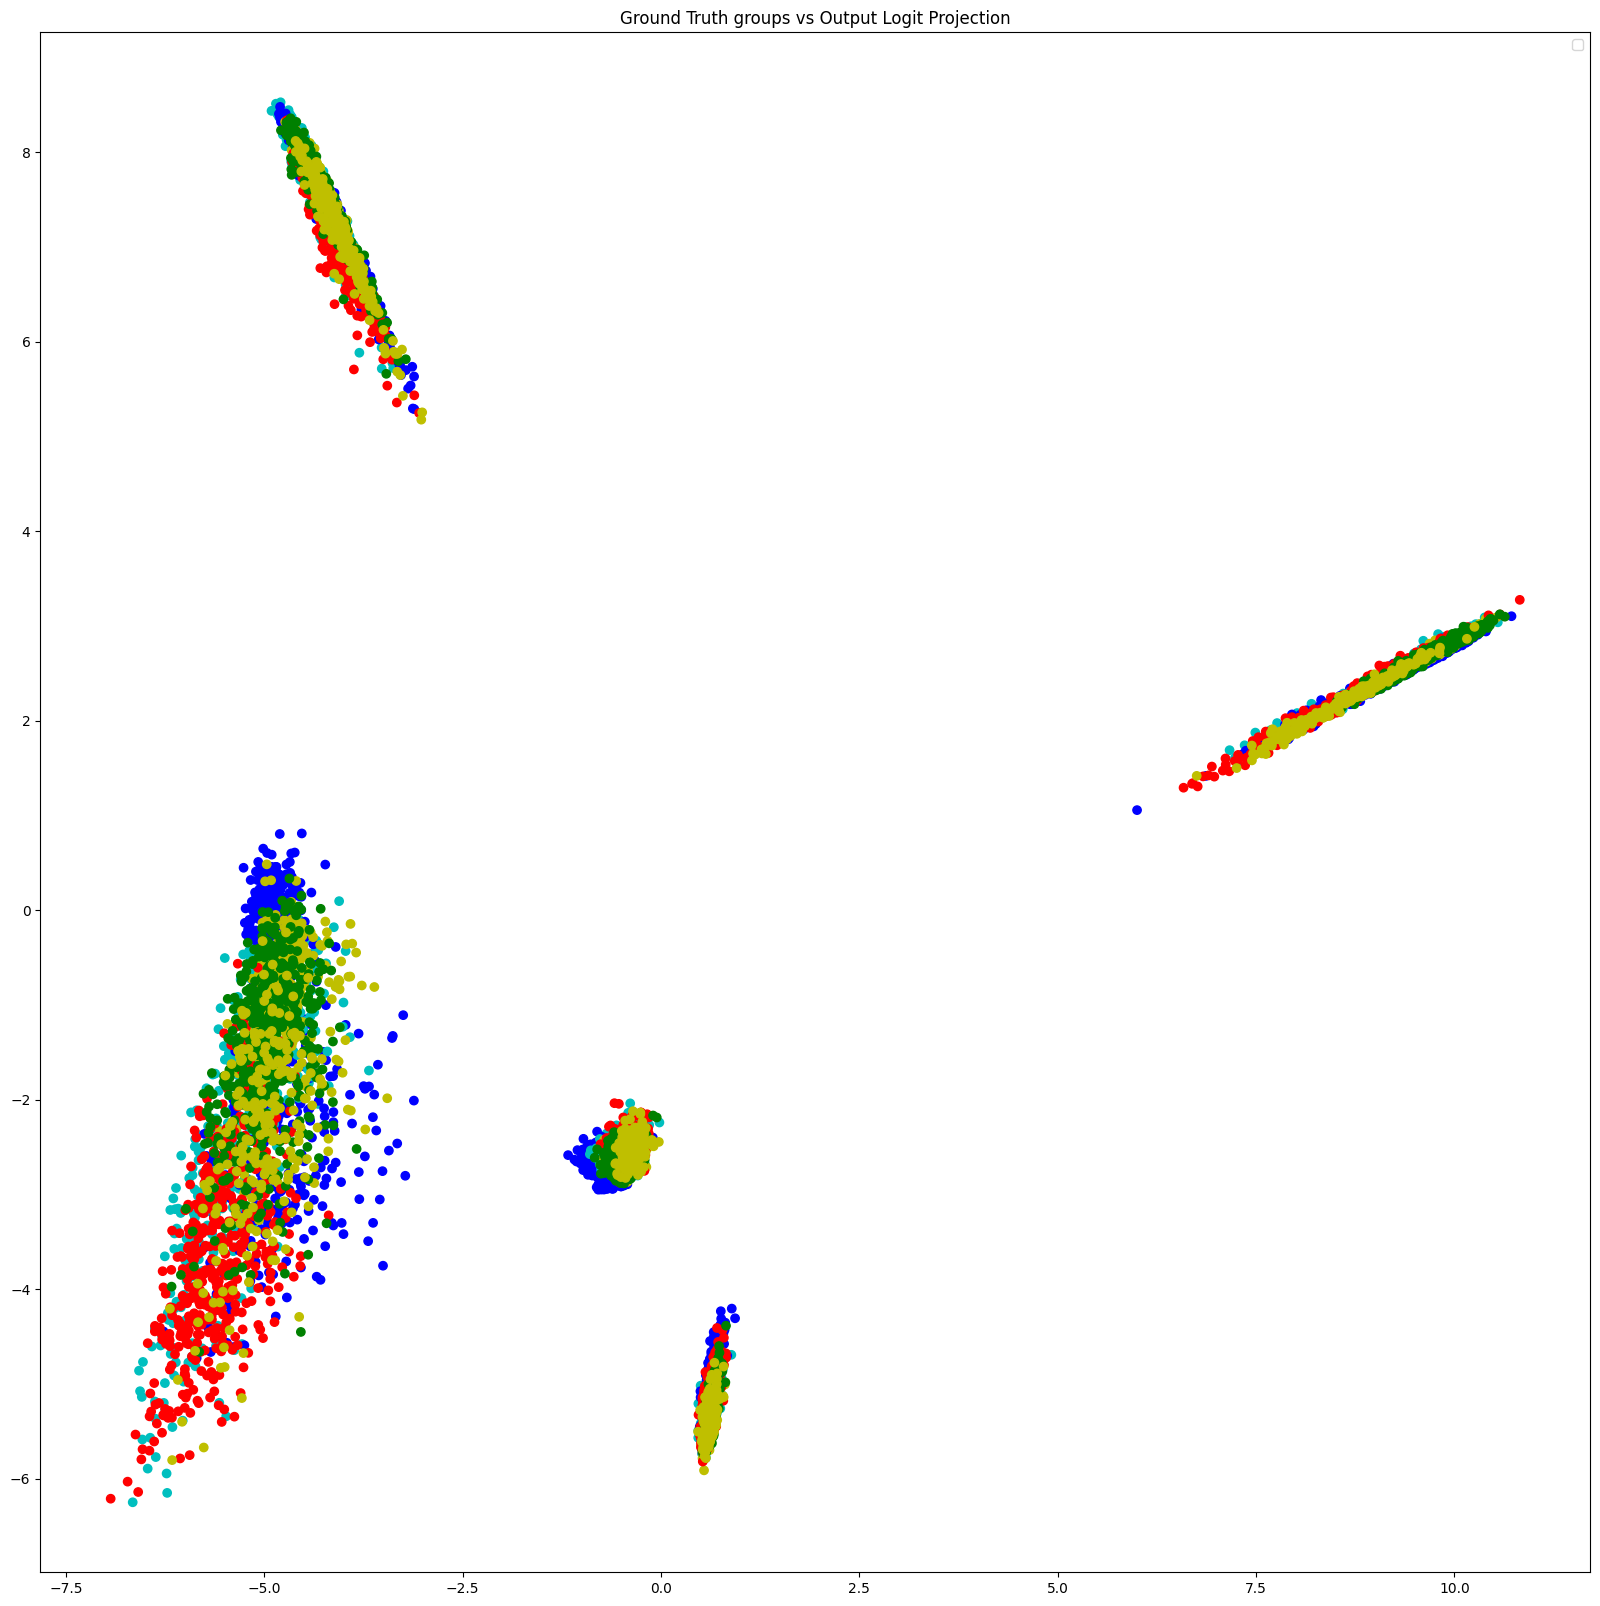

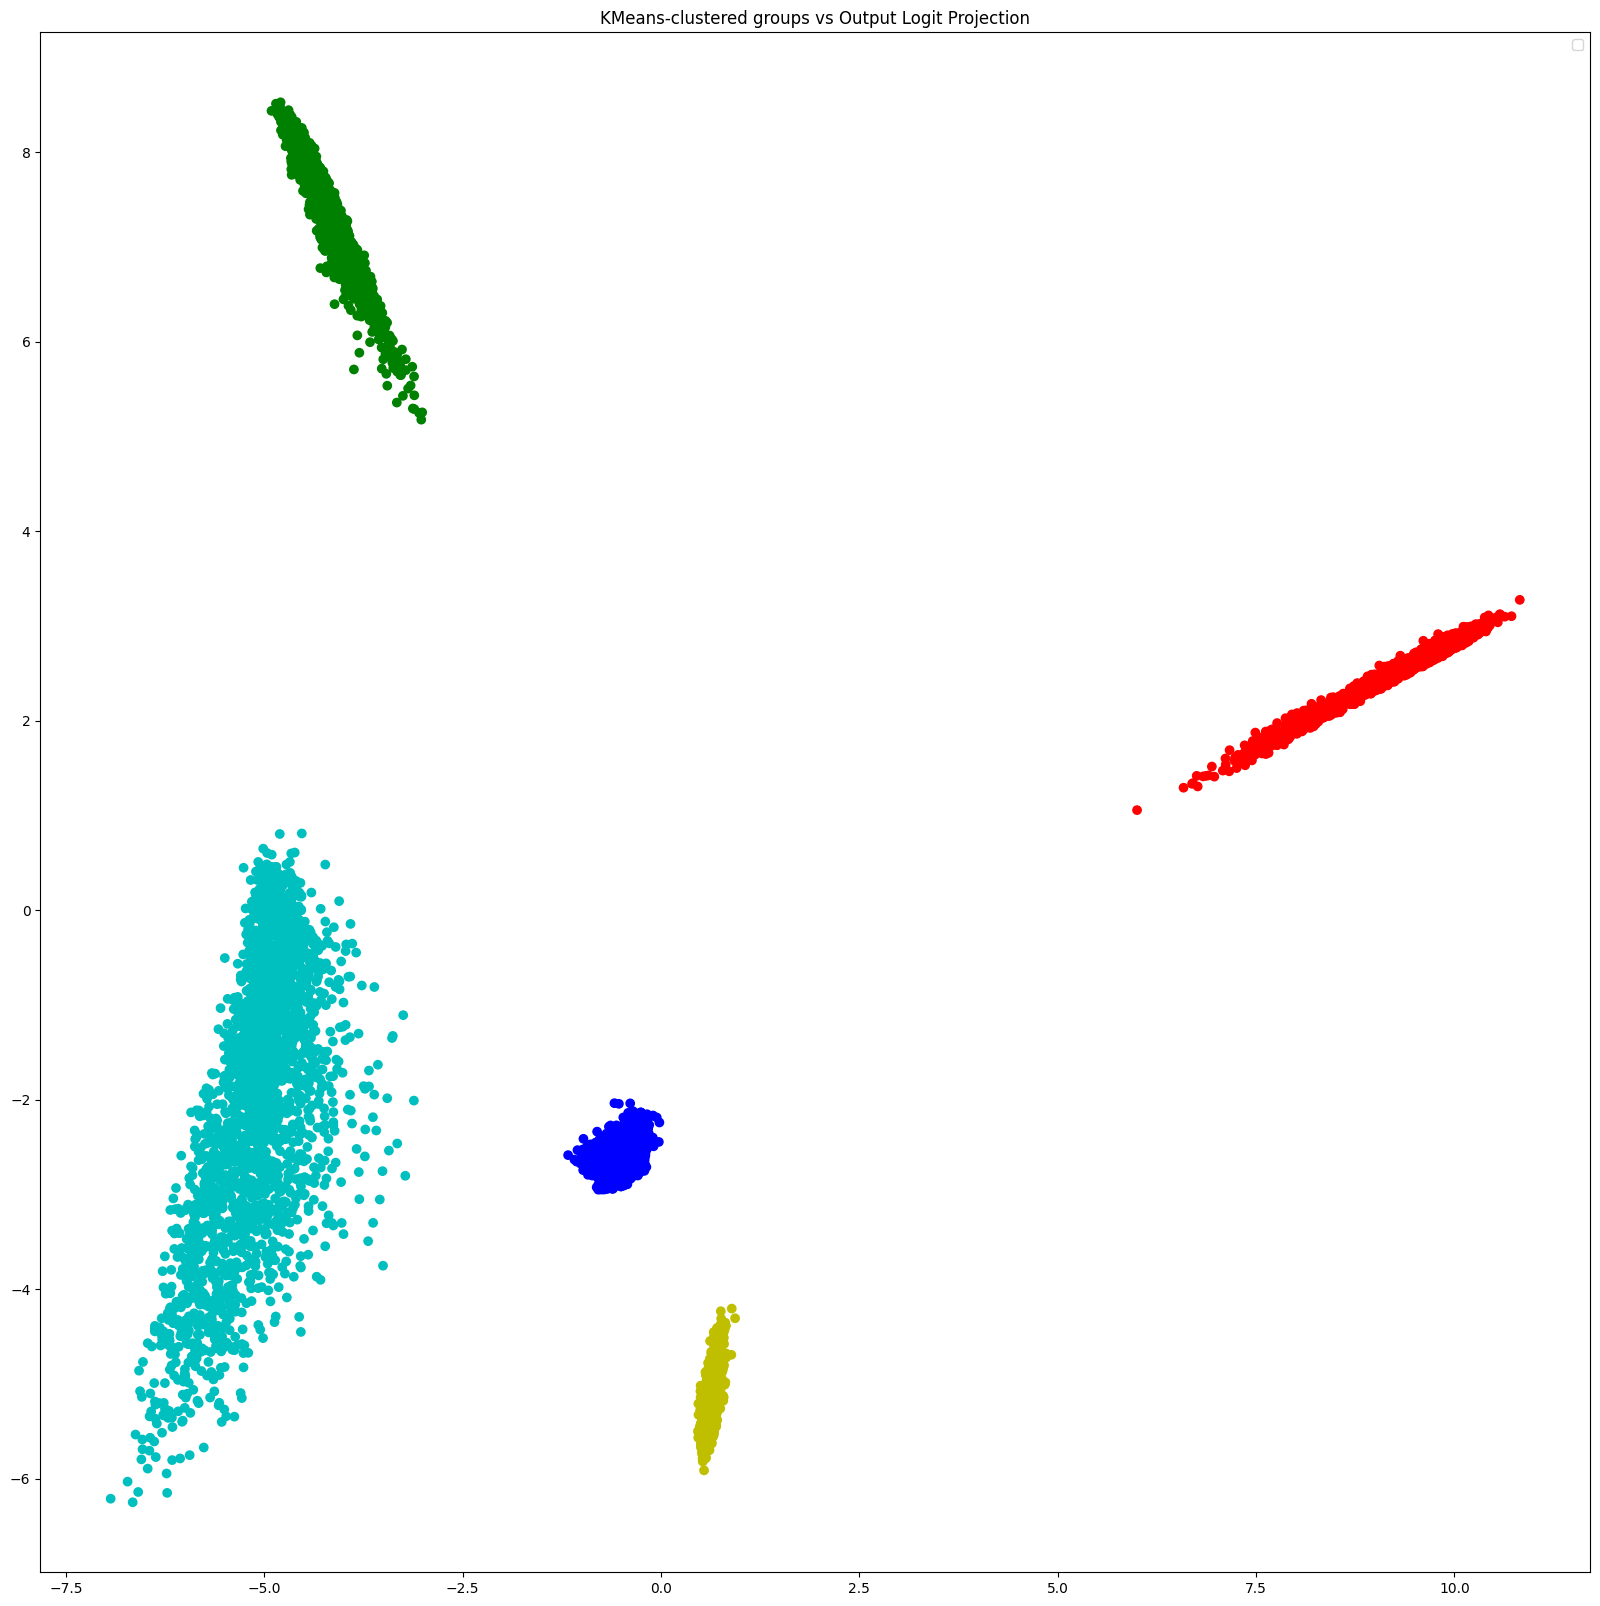

In [7]:
import matplotlib.pyplot as plt
# from umap import UMAP
# umap = UMAP(n_components=2)
# transformed = umap.fit_transform(outputs)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(outputs)

colors = np.array(['b','r','c','g','y'])[labels]
plt.figure(figsize=(20,20))
plt.title("Ground Truth groups vs Output Logit Projection")
plt.scatter(transformed[:,0],transformed[:,1],c=colors)
plt.legend({})
plt.show()

colors = np.array(['b','r','c','g','y'])[predicted_groups]
plt.figure(figsize=(20,20))
plt.title("KMeans-clustered groups vs Output Logit Projection")
plt.scatter(transformed[:,0],transformed[:,1],c=colors)
plt.legend({})
plt.show()

<Figure size 2000x2000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

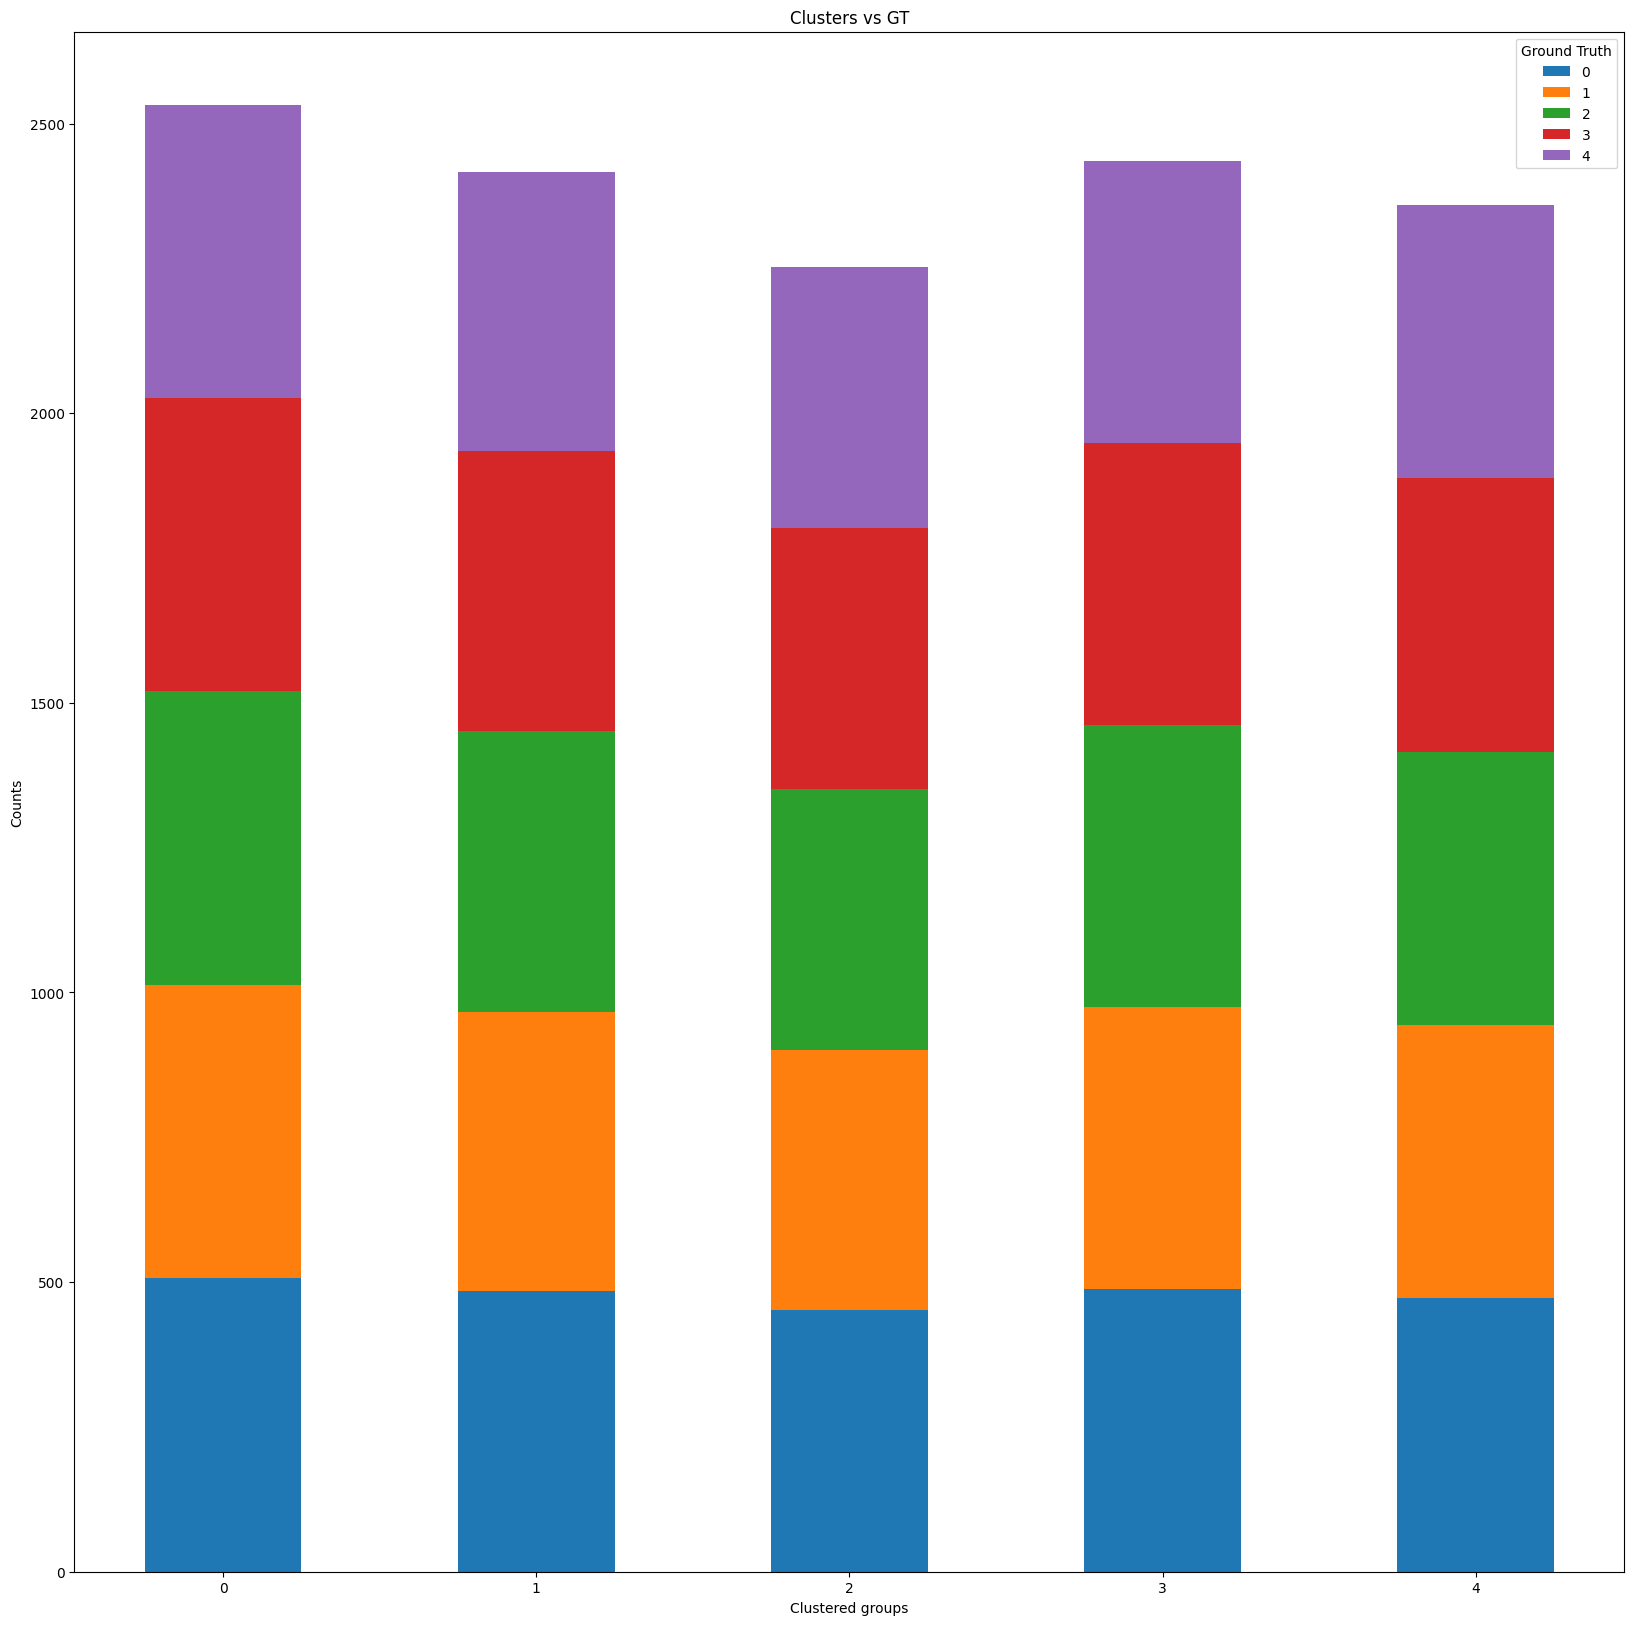

In [8]:
plt.figure(figsize=(20,20))

import numpy as np
import matplotlib.pyplot as plt

# Sample data: two categorical variables in separate numpy arrays
category1 = np.arange(5)
category2 = np.arange(5)
values = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        values[i][j] = np.sum((predicted_groups==i) & (labels==j))

# Define the positions for the bars
bar_width = 0.5
positions = np.arange(len(category1))

# Plotting the stacked bar chart
plt.figure()
fig, ax = plt.subplots(figsize=(20,20))

# Plot each row in 'values' as a separate bar segment
bottom = np.zeros(len(category1))
for i in range(len(category2)):
    ax.bar(positions, values[i], bar_width, bottom=bottom, label=category2[i])
    bottom += values[i]  # Update the bottom for the next segment

# Set labels and title
ax.set_xticks(positions)
ax.set_xticklabels(category1)
ax.set_ylabel('Counts')
ax.set_xlabel('Clustered groups')
ax.set_title('Clusters vs GT')
ax.legend(title='Ground Truth')

plt.show()

# looks like something

# Group-balance ERM

In [9]:
cnn.load_state_dict(base_cnn_weights)

trainer = GroupBalanceBatchERM(
            model = cnn, 
            group_partition=train_ds.group_partition,
            trainset = train_ds, 
            batch_size = 64, 
            optimizer = torch.optim.Adam(cnn.parameters(),lr = 1e-3), 
            num_epochs=1,
            verbose=True
          )
trainer.train()

Epoch 0: 100%|██████████| 751/751 [02:49<00:00,  4.42batch/s, accuracy=100.0%, loss=0.000523]


In [10]:
evaluator = Evaluator(
    testset=test_ds,
    group_partition=test_ds.group_partition,
    group_weights=train_ds.group_weights,
    batch_size=64,
    model=cnn,
    device='cpu',
    verbose=True
)
evaluator.evaluate()
print('worse accuracy',evaluator.worst_group_accuracy)
print('average group accuracy',evaluator.average_accuracy)
print('spurious_attribute_prediction',evaluator.evaluate_spurious_attribute_prediction())

Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:14,  1.71it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:13,  1.72it/s]

Group (0, 1) Accuracy: 83.92434988179669


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:12,  1.71it/s]

Group (0, 2) Accuracy: 56.737588652482266


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:02<00:12,  1.72it/s]

Group (0, 3) Accuracy: 79.66903073286052


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:11,  1.73it/s]

Group (0, 4) Accuracy: 83.451536643026


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:10,  1.74it/s]

Group (1, 0) Accuracy: 62.836185819070906


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:04<00:10,  1.73it/s]

Group (1, 1) Accuracy: 99.26650366748166


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:04<00:09,  1.73it/s]

Group (1, 2) Accuracy: 78.18627450980392


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:09,  1.74it/s]

Group (1, 3) Accuracy: 73.77450980392157


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:05<00:08,  1.76it/s]

Group (1, 4) Accuracy: 74.50980392156863


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:07,  1.78it/s]

Group (2, 0) Accuracy: 70.66666666666667


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:06<00:07,  1.80it/s]

Group (2, 1) Accuracy: 63.2


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:07<00:06,  1.75it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:08<00:06,  1.73it/s]

Group (2, 3) Accuracy: 79.2


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:08<00:05,  1.77it/s]

Group (2, 4) Accuracy: 56.95187165775401


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:09<00:05,  1.77it/s]

Group (3, 0) Accuracy: 63.06532663316583


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:09<00:04,  1.77it/s]

Group (3, 1) Accuracy: 64.98740554156171


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:10<00:03,  1.75it/s]

Group (3, 2) Accuracy: 65.99496221662469


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:10<00:03,  1.76it/s]

Group (3, 3) Accuracy: 98.48866498740554


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:11<00:02,  1.77it/s]

Group (3, 4) Accuracy: 67.2544080604534


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:11<00:02,  1.77it/s]

Group (4, 0) Accuracy: 73.29974811083123


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:12<00:01,  1.77it/s]

Group (4, 1) Accuracy: 48.36272040302267


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:13<00:01,  1.76it/s]

Group (4, 2) Accuracy: 44.08060453400504


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:13<00:00,  1.76it/s]

Group (4, 3) Accuracy: 72.72727272727273


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:14<00:00,  1.75it/s]

Group (4, 4) Accuracy: 99.24242424242425
worse accuracy ((4, 2), 44.08060453400504)
average group accuracy 99.2419791574154


spurious_attribute_prediction 40.55


In [11]:
outputs = []
labels = []
for i in range(len(val_ds)):
    img, label = val_ds[i]
    output = cnn(torch.tensor(img).unsqueeze(0)).squeeze().detach().cpu().numpy()
    outputs.append(output)
    labels.append(label)
    
outputs = np.array(outputs)
labels = np.array(labels)

# make 5 clusters
from sklearn.cluster import BisectingKMeans
cluster = BisectingKMeans(n_clusters=5,)
predicted_groups = cluster.fit_predict(outputs)
predicted_groups

/tmp/ipykernel_17/692930056.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = cnn(torch.tensor(img).unsqueeze(0)).squeeze().detach().cpu().numpy()


array([3, 3, 3, ..., 2, 4, 1], dtype=int32)

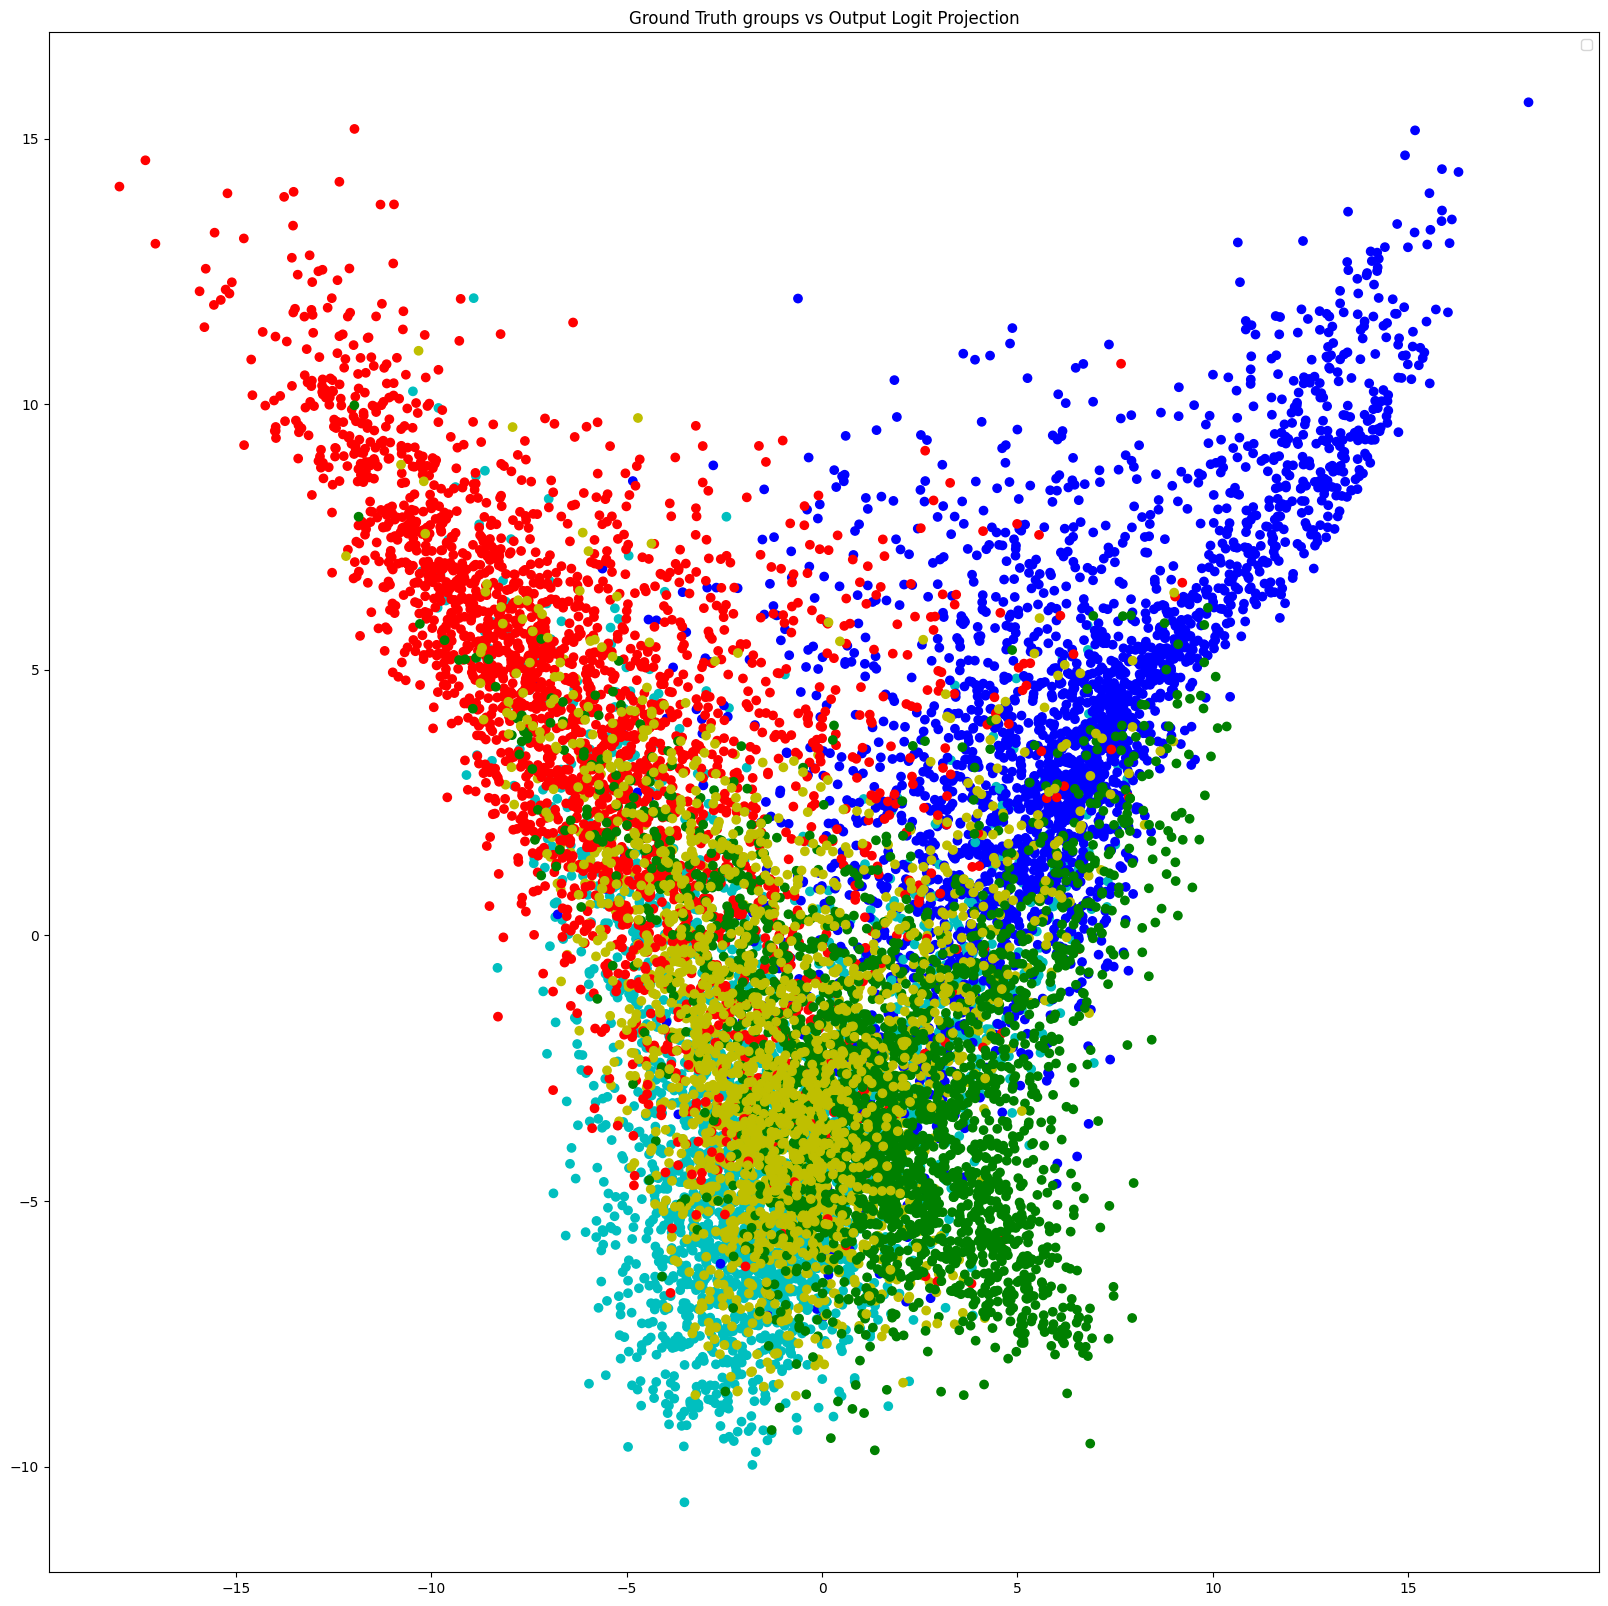

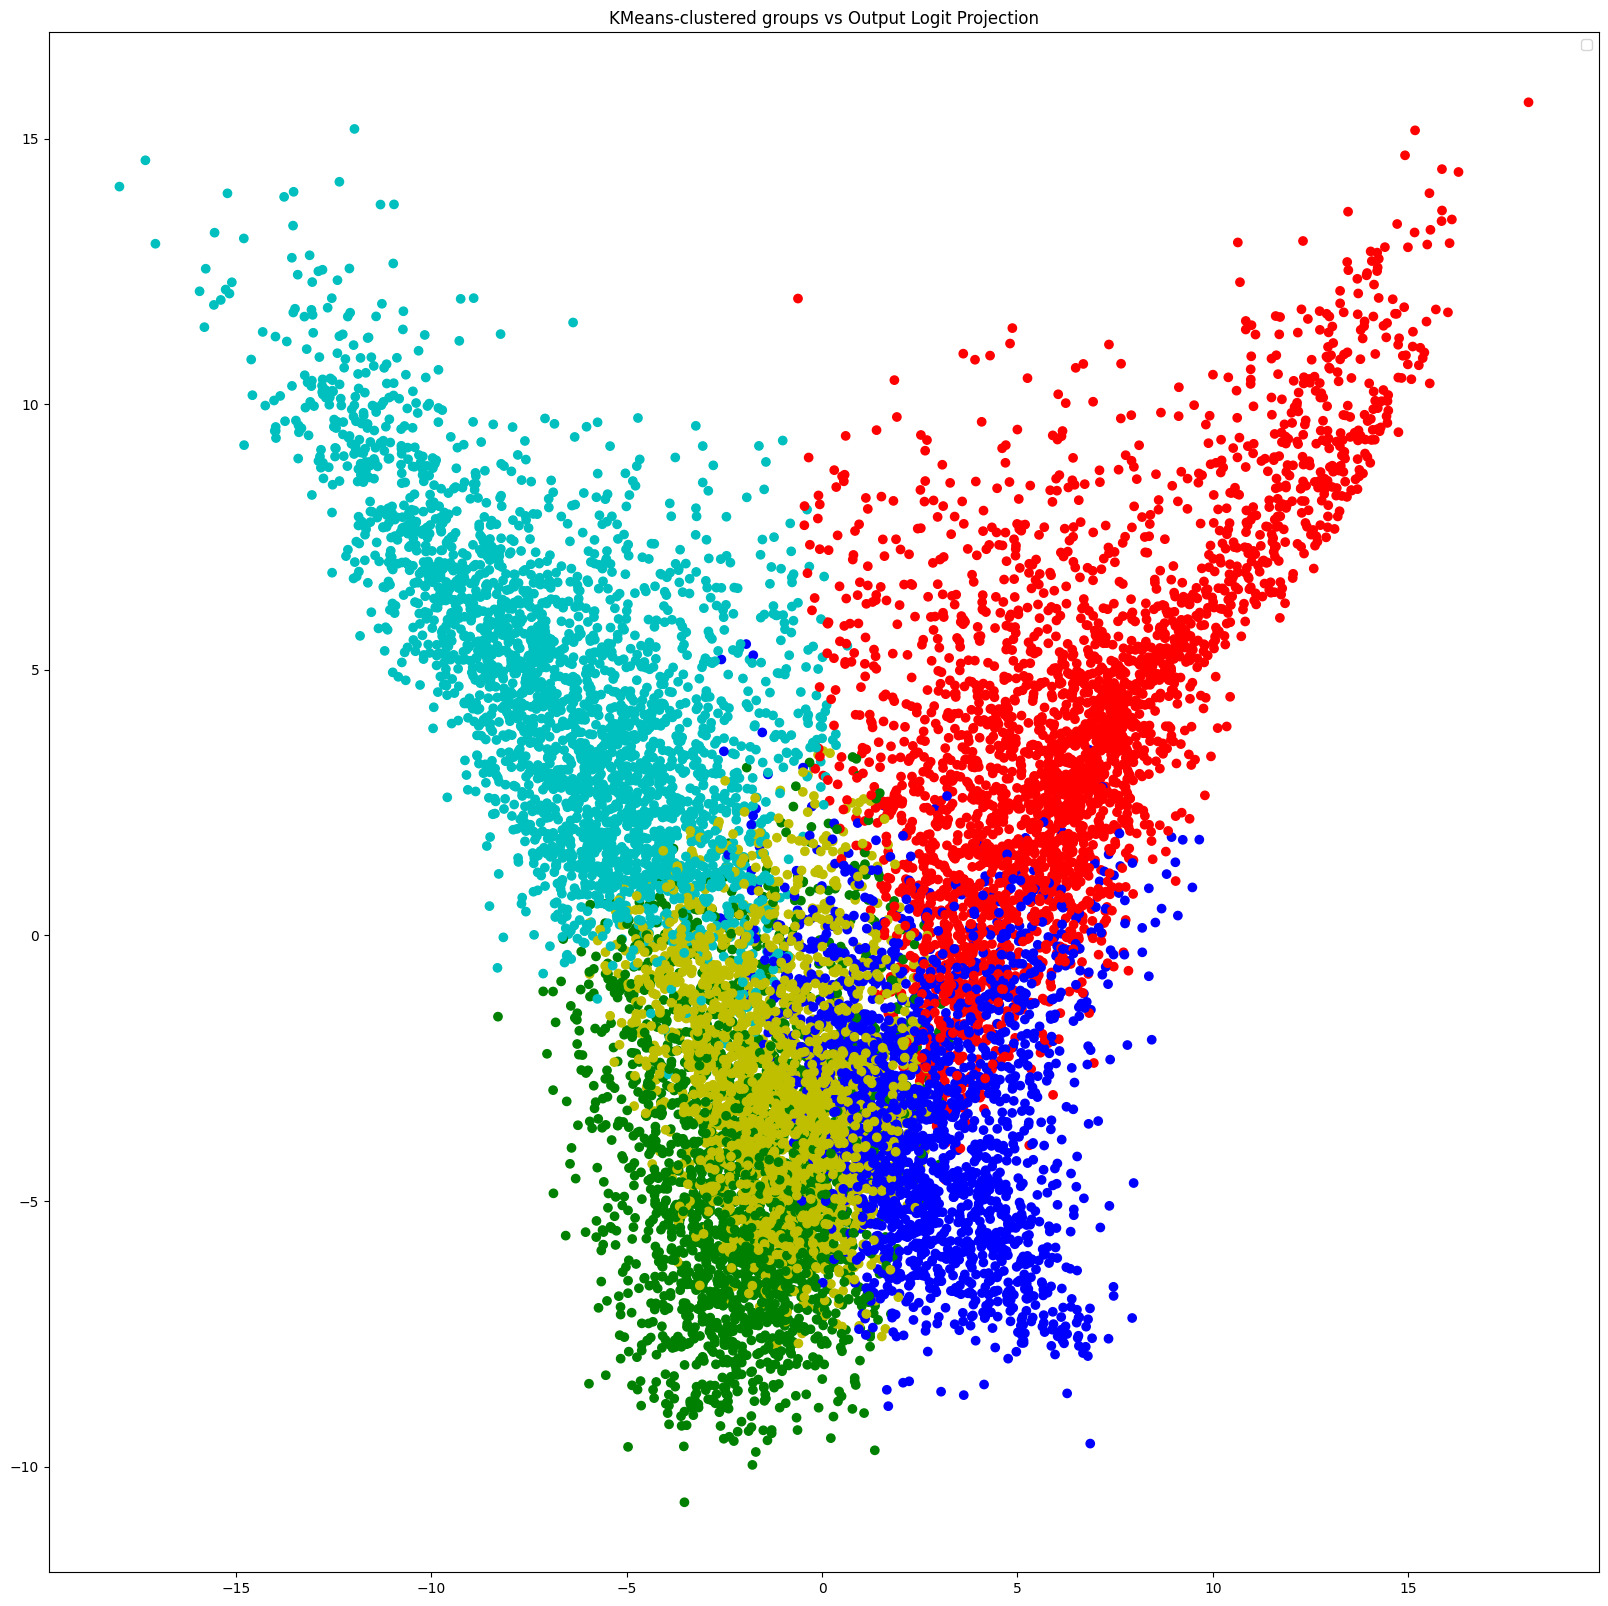

In [12]:

import matplotlib.pyplot as plt
# from umap import UMAP
# umap = UMAP(n_components=2)
# transformed = umap.fit_transform(outputs)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(outputs)

colors = np.array(['b','r','c','g','y'])[labels]
plt.figure(figsize=(20,20))
plt.title("Ground Truth groups vs Output Logit Projection")
plt.scatter(transformed[:,0],transformed[:,1],c=colors)
plt.legend({})
plt.show()

colors = np.array(['b','r','c','g','y'])[predicted_groups]
plt.figure(figsize=(20,20))
plt.title("KMeans-clustered groups vs Output Logit Projection")
plt.scatter(transformed[:,0],transformed[:,1],c=colors)
plt.legend({})
plt.show()

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

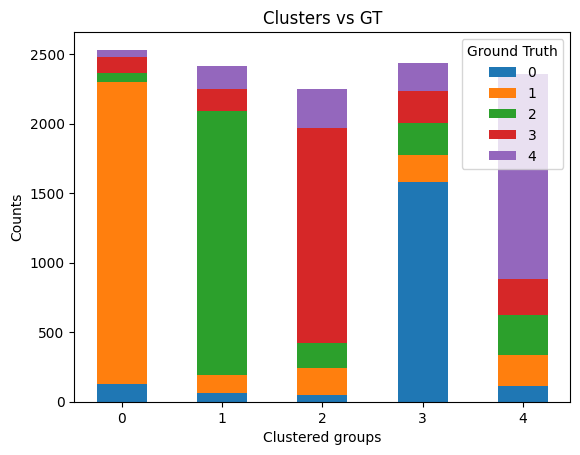

In [13]:
plt.figure(figsize=(20,20))

import numpy as np
import matplotlib.pyplot as plt

# Sample data: two categorical variables in separate numpy arrays
category1 = np.arange(5)
category2 = np.arange(5)
values = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        values[i][j] = np.sum((predicted_groups==i) & (labels==j))

# Define the positions for the bars
bar_width = 0.5
positions = np.arange(len(category1))

# Plotting the stacked bar chart
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()

# Plot each row in 'values' as a separate bar segment
bottom = np.zeros(len(category1))
for i in range(len(category2)):
    ax.bar(positions, values[i], bar_width, bottom=bottom, label=category2[i])
    bottom += values[i]  # Update the bottom for the next segment

# Set labels and title
ax.set_xticks(positions)
ax.set_xticklabels(category1)
ax.set_ylabel('Counts')
ax.set_xlabel('Clustered groups')
ax.set_title('Clusters vs GT')
ax.legend(title='Ground Truth')

plt.show()

This sampling(?) strategy seems to perform better and is less affected by spurious correlations